# Setup

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy_indexed as npi
from tqdm.notebook import tqdm

from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive

In [2]:
import os
import pathlib
from typing import List, Tuple
import numpy as np
import cv2 as cv
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv


BASE_DIR = pathlib.Path(__name__).resolve().parent.parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

## Import core modules

In [3]:
import sys
import pathlib
SRC_DIR = str(pathlib.Path(__name__).resolve().parent.parent)
sys.path.append(SRC_DIR)

In [4]:
from plot2data.setup_logger import logger

In [5]:
from plot2data.utils.read_image import read_image_rgb, read_image_gray
from plot2data.utils.drawing import draw_image, draw_points_on_canvas, draw_points_on_image, \
    draw_bbox

In [6]:
from plot2data.core.template_match import template_match, detect_points, \
    find_tolerance_limit

from plot2data.core.clustering import simplify_points, agglomerative_clustering, meanshift_clustering

from plot2data.core.preprocess import replace_black_pixels

from plot2data.core.conv_map_operations import invert_convolution_map, normalize_map, \
    get_first_N_maximums, remove_nan_inf


from plot2data.core.process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale, reconstruct_template_mask

from plot2data.core.hough_transform import calc_gradients, build_hough_model, fill_accumulator

from plot2data.core.parameters_search import linear_parameter_transform, get_corr_map_maximums

from plot2data.core.nms import apply_nms, point_to_bbox, get_bbox_from_point, get_bbox_center

In [7]:
# convolution implementation
from plot2data.core.convolution_from_stratch import get_image_part, sqdiff, \
    compute_mask_pixel_ratio, compute_mask_pixel_ratio_v2, sqdiff_normed_modification, \
    sqdiff_normed, cv_sqdiff_normed

# Pipeline

## Upload plot and template

In [8]:
PLOT_NUMBER = 6
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [9]:
source_image = read_image_rgb(PLOT_PATH)
source_template = read_image_rgb(TEMPLATE_PATH)

image = replace_black_pixels(source_image)
template = replace_black_pixels(source_template)

DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 0
DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 0


In [10]:
h_image, w_image = image.shape[0], image.shape[1]
h_template, w_template = template.shape[0], template.shape[1]

h_image, w_image

(898, 1755)

([], [])

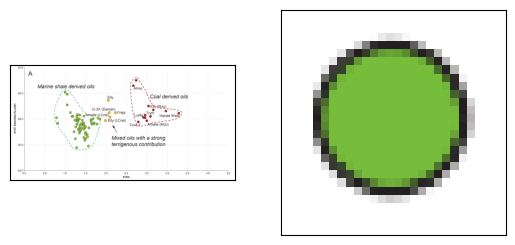

In [11]:
plt.subplot(1, 2, 1)
draw_image(image)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template)
plt.xticks([]); plt.yticks([])

## Add ROI (optional)

In [12]:
# imshow_interactive(image)

In [13]:
# x_min, x_max, y_min, y_max = 221, 458, 47, 418
# roi_bbox = (x_min, x_max, y_min, y_max)

# image = crop_image(image, roi_bbox)

In [14]:
# imshow_interactive(image)

## Tresholding

([], [])

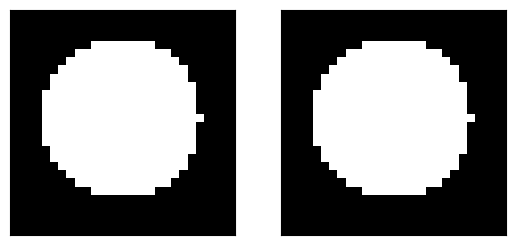

In [12]:
TRESHOLD_VALUE = 190
template_mask = template_tresholding(template, TRESHOLD_VALUE)
new_template_mask = reconstruct_template_mask(template_mask)

fig = plt.figure()
plt.subplot(1, 2, 1)
draw_image(template_mask)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(new_template_mask)
plt.xticks([]); plt.yticks([])

## Template matching

In [13]:
# method_name = 'SQDIFF_MODIFICATION_V3_WITH_HOUGH'
method_name = 'SQDIFF_MODIFICATION_V2'
method = "cv.TM_SQDIFF_NORMED"

convolution_map, _ = template_match(image, template, template_mask, method)
convolution_map2, _ = template_match(image, template, new_template_mask, method)

DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 0.8545219)
DEBUG - template_match.py - template_match: Convolution map was inverted
DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 0.8545219)
DEBUG - template_match.py - template_match: Convolution map was inverted


## Hough transform

In [14]:
## Hough transfrom
hough_model = build_hough_model(template)
accumulator = fill_accumulator(hough_model, source_image)
accumulator_normed = normalize_map(accumulator)

# (подгон) ((но работает))
# обрезаем аккумулятор так, чтобы его размер был равен размеру корреляционной карты
x_min = w_template // 2
y_min = h_template // 2
if w_template % 2 == 0:
    x_max = accumulator_normed.shape[1] - w_template // 2
else:
    x_max = accumulator_normed.shape[1] - w_template // 2 - 1

if h_template % 2 == 0:
    y_max = accumulator_normed.shape[0] - h_template // 2
else:
    y_max = accumulator_normed.shape[0] - h_template // 2 - 1

accumulator_cropped = crop_image(accumulator, bbox=(x_min, x_max, y_min, y_max))
accumulator_normed_cropped = crop_image(accumulator_normed, bbox=(x_min, x_max, y_min, y_max))

convolution_map_normed = normalize_map(convolution_map)
convolution_map2_normed = normalize_map(convolution_map2)

assert convolution_map_normed.shape == accumulator_normed_cropped.shape

## Combine convolution maps

In [15]:
convolution_map = normalize_map(convolution_map)
convolution_map2 = normalize_map(convolution_map2)

convolution_map3 = convolution_map + 0.7 * convolution_map2
convolution_map3 = normalize_map(convolution_map3)

convolution_map4 = convolution_map + 0.6 * accumulator_normed_cropped

In [51]:
# imshow_interactive(convolution_map)

## Interactive parameters search

1) `points_num` - отвечает за количество точек (чем больше, тем больше точек детектируется)

`points_num` = 0 => 1 точка

`points_num` = 100 => бесконечно много точек 


2) `points_density` - отвечает за плотность точек (чем больше, тем **разреженнее** результат)

`points_density` = 0 => не применяем NMS

`points_density` = 100 => убираем очень много соседей

In [ ]:

@interact(points_num=widgets.FloatSlider(value=20, min=0, max=100, step=1),
          points_density=widgets.FloatSlider(value=20, min=0, max=100, step=1))
def visualize(points_num, points_density):
    

    CORR_MAP = convolution_map3
    
    ## transform parameters:
    corr_map_treshold = linear_parameter_transform(points_num, a=-0.01, b=1)
    iou_treshold = linear_parameter_transform(points_density, a=-0.01, b=1)

    # ## get max points
    # maximums = np.where(CORR_MAP >= corr_map_treshold)
    # y_points, x_points = maximums
    # points = np.stack((x_points, y_points)).T
    # number_of_maximums = len(points)

    max_points, number_of_maximums = get_corr_map_maximums(
        correlation_map=CORR_MAP,
        treshold=corr_map_treshold
    )
    
    # ## NMS
    # bboxes, scores = get_bbox_from_point(points, w_template, h_template, CORR_MAP)
    # keep = nms(bboxes, scores, iou_threshold=iou_treshold)
    # bboxes_nms = bboxes[keep]
    # x_nms, y_nms = get_bbox_center(bboxes_nms)
    # actual_points = np.stack((x_nms, y_nms)).T

    actual_points = apply_nms(
        points=max_points,
        correlation_map=CORR_MAP,
        iou_treshold=iou_treshold,
        bbox_width=w_template,
        bbox_height=h_template
    )
    x_nms = actual_points[:, 0]
    y_nms = actual_points[:, 1]

    ## draw founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)
    plt.scatter(x_nms, y_nms, s=60, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    # plt.xticks([]); plt.yticks([]);
    plt.title(f"{corr_map_treshold=}, {iou_treshold=}, {number_of_maximums=}")
    plt.show()

    # ## draw founded points on clear canvas
    # plt.figure(figsize=(10, 6))
    # draw_points_on_canvas(actual_points, source_image)